Um IDS Peak API zu nutzen: 

- ids_peak C://Programme/IDS/ids_peak/generic_api/binding/python/wheel/x86_64
- ids_peak_ipl C://Programme/IDS/ids_peak/generic_sdk/binding/python/wheel/x86_64
- in Explorer öffnen
- Rechtsklick irgendwo und PowerShell(Terminal ging auch) öffnen
- pip install und Dateinamen mit Erweiterung angeben

Code ist entsprechend lokal gespeichertem Beispiel Code (ca. obiger Pfad)

In [52]:
from ids_peak import ids_peak
from ids_peak import ids_peak_ipl_extension
import ids_peak_ipl.ids_peak_ipl
from ids_peak_ipl.ids_peak_ipl import Image, PixelFormatName_BGR8, ConversionMode_HighQuality,ConversionMode_Fast
import matplotlib.pyplot as plt
import cv2
import numpy as np

# presets
arucos = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
cam = 0

#setup ids_peak
ids_peak.Library.Initialize()
device_manager = ids_peak.DeviceManager.Instance()
print(device_manager)

<ids_peak.ids_peak.DeviceManager; proxy of <Swig Object of type 'peak::DeviceManager *' at 0x000001CD557491D0> >


0: GV-580xSE-C (IDS GigE Vision @ "Ethernet" (D8-CB-8A-39-0A-9C); IDS GenICam Producer (GEVK)v.1.11.0.1)
Model Name: GV-580xSE-C
User ID: 
Sensor Name: Sony IMX183CQJ-J
Exposure Time: 100163.41666666667
Digital Colorgain (Red):	1.5399999618530273
Digital Colorgain (Green):	1.0
Digital Colorgain (Blue):	2.130000114440918
Max. resolution (w x h): 5536 x 3692
PayLoadSize: 20093184
num buffers required: 3
Closing Device Manager


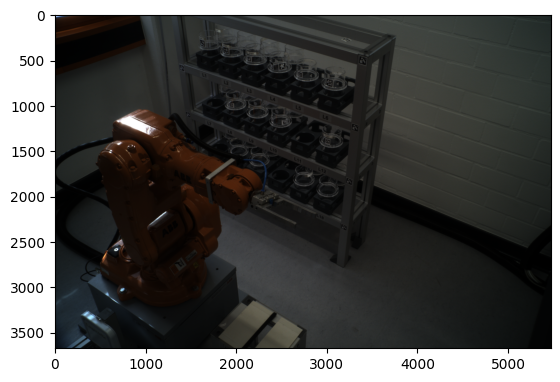

In [53]:
try: 
    device_manager.Update()
    if device_manager.Devices().empty():
        print("no devices found")
    else:
        for i, device in enumerate(device_manager.Devices()):
            print(str(i) + ": " + device.ModelName() + " ("
                  + device.ParentInterface().DisplayName() + "; "
                  + device.ParentInterface().ParentSystem().DisplayName() + "v."
                  + device.ParentInterface().ParentSystem().Version() + ")")
        # open first device
        device = device_manager.Devices()[cam].OpenDevice(ids_peak.DeviceAccessType_Control)

        # get the rmeote device node map
        nodemap_remote_device = device.RemoteDevice().NodeMaps()[0]
        # print model name and user ID
        print("Model Name: " + nodemap_remote_device.FindNode("DeviceModelName").Value())
        try:
            print("User ID: " + nodemap_remote_device.FindNode("DeviceUserID").Value())
        except ids_peak.Exception:
            print("User ID: (unknown)")
            
        # print sensor information, not knowing if device has the node "SensorName"
        try:
            print("Sensor Name: " + nodemap_remote_device.FindNode("SensorName").Value())
        except ids_peak.Exception:
            print("Sensor Name: " + "(unknown)")

        # set exposure time
        exposure_time_percentage = 0.05
        min_exposure_time = nodemap_remote_device.FindNode("ExposureTime").Minimum()
        max_exposure_time = nodemap_remote_device.FindNode("ExposureTime").Maximum()
        set_exposure_time = min_exposure_time + exposure_time_percentage*(max_exposure_time - min_exposure_time) if exposure_time_percentage <= 1 else max_exposure_time
        nodemap_remote_device.FindNode("ExposureTime").SetValue(set_exposure_time)
        print(f"Exposure Time: {set_exposure_time}")

        # set fps
        fps_percentage = 1
        min_frame_rate = nodemap_remote_device.FindNode("AcquisitionFrameRate").Minimum()
        max_frame_rate = nodemap_remote_device.FindNode("AcquisitionFrameRate").Maximum()
        set_frame_rate = min_frame_rate + fps_percentage*(max_frame_rate - min_frame_rate) if fps_percentage <= 1 else max_frame_rate
        nodemap_remote_device.FindNode("AcquisitionFrameRate").SetValue(set_frame_rate)

        # set color selector to red and set gain value
        nodemap_remote_device.FindNode("GainSelector").SetCurrentEntry("DigitalRed")
        nodemap_remote_device.FindNode("Gain").SetValue(1.54)
        print(f"Digital Colorgain (Red):\t{str(nodemap_remote_device.FindNode('Gain').Value())}")
        
        # set color selector to green and set gain value
        nodemap_remote_device.FindNode("GainSelector").SetCurrentEntry("DigitalGreen")
        nodemap_remote_device.FindNode("Gain").SetValue(1)
        print(f"Digital Colorgain (Green):\t{str(nodemap_remote_device.FindNode('Gain').Value())}")

        # set color selector to blue and set gain value
        nodemap_remote_device.FindNode("GainSelector").SetCurrentEntry("DigitalBlue")
        nodemap_remote_device.FindNode("Gain").SetValue(2.13)
        print(f"Digital Colorgain (Blue):\t{str(nodemap_remote_device.FindNode('Gain').Value())}")
        
        # print resolution
        try:
            print("Max. resolution (w x h): "
                  + str(nodemap_remote_device.FindNode("WidthMax").Value()) + " x "
                  + str(nodemap_remote_device.FindNode("HeightMax").Value()))
        except ids_peak.Exception:
            print("Max. resolution (w x h): (unknown)")
            
        dataStreams = device.DataStreams()
        if dataStreams.empty():
            print("dataStreams error ... not described which error") 
        dataStream = device.DataStreams()[0].OpenDataStream();
        nodemapDataStream = dataStream.NodeMaps()[0];
        try:
            if dataStream:
                # Flush queue and prepare all buffers for revoking
                dataStream.Flush(ids_peak.DataStreamFlushMode_DiscardAll)
                 
                # Clear all old buffers
                for buffer in dataStream.AnnouncedBuffers():
                   dataStream.RevokeBuffer(buffer)
                payload_size = nodemap_remote_device.FindNode("PayloadSize").Value()
                print(f"PayLoadSize: {payload_size}")
                # Get number of minimum required buffers
                num_buffers_min_required = dataStream.NumBuffersAnnouncedMinRequired()
                print(f"num buffers required: {num_buffers_min_required}")
                
                # Alloc buffers
                for count in range(num_buffers_min_required):
                    buffer = dataStream.AllocAndAnnounceBuffer(payload_size)
                    dataStream.QueueBuffer(buffer)
                
        except Exception as e:
            print(f"Exception while buffer allocating: {str(e)}")
        
        # start acquisition
        try:
            dataStream.StartAcquisition(ids_peak.AcquisitionStartMode_Default, ids_peak.DataStream.INFINITE_NUMBER)
            nodemap_remote_device.FindNode("TLParamsLocked").SetValue(1)
            nodemap_remote_device.FindNode("AcquisitionStart").Execute()
        except Exception as e:
            print(str(e))
        
        # receive image
        try: 
            buffer = dataStream.WaitForFinishedBuffer(5000)
            image = ids_peak_ipl_extension.BufferToImage(buffer)
            image = image.ConvertTo(PixelFormatName_BGR8, ConversionMode_Fast)
            dataStream.QueueBuffer(buffer)
        except Exception as e:
            print(str(e))
        # convert image to numpy array
        img = np.copy(image.get_numpy_3D())
        
except Exception as e:
    print("Exception: " + str(e))
finally:
    print("Closing Device Manager")
    ids_peak.Library.Close()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [54]:
(corners, ids, rejected) = cv2.aruco.detectMarkers(img, arucos,)
# print(f"Corners: {corners}")
# print(f"Ids: {ids}")
# print(rejected)
# loop over ids and create a suitable array with ids and corner coordinates
markers = []

# refactor corners
for i, id in enumerate(ids):
    marker_corners = []
    for j, entry in enumerate(corners[i]):
        marker_corners.append([corners[i][j][0], corners[i][j][1]])
    markers.append([id, marker_corners])

print(markers)



[[array([0], dtype=int32), [[array([3265., 1874.], dtype=float32), array([3206., 1848.], dtype=float32)]]], [array([0], dtype=int32), [[array([1491., 1130.], dtype=float32), array([1450., 1113.], dtype=float32)]]], [array([8], dtype=int32), [[array([2987.,  770.], dtype=float32), array([2991.,  701.], dtype=float32)]]], [array([0], dtype=int32), [[array([1422.,  619.], dtype=float32), array([1378.,  601.], dtype=float32)]]], [array([7], dtype=int32), [[array([2538.,  592.], dtype=float32), array([2471.,  603.], dtype=float32)]]], [array([0], dtype=int32), [[array([3419.,  554.], dtype=float32), array([3347.,  530.], dtype=float32)]]], [array([6], dtype=int32), [[array([1859.,  415.], dtype=float32), array([1853.,  351.], dtype=float32)]]], [array([0], dtype=int32), [[array([3206., 2375.], dtype=float32), array([3152., 2351.], dtype=float32)]]], [array([0], dtype=int32), [[array([3331., 1285.], dtype=float32), array([3267., 1261.], dtype=float32)]]]]


[[array([0], dtype=int32), [[array([3265., 1874.], dtype=float32), array([3206., 1848.], dtype=float32)]]], [array([0], dtype=int32), [[array([1491., 1130.], dtype=float32), array([1450., 1113.], dtype=float32)]]], [array([0], dtype=int32), [[array([1422.,  619.], dtype=float32), array([1378.,  601.], dtype=float32)]]], [array([0], dtype=int32), [[array([3419.,  554.], dtype=float32), array([3347.,  530.], dtype=float32)]]], [array([0], dtype=int32), [[array([3206., 2375.], dtype=float32), array([3152., 2351.], dtype=float32)]]], [array([0], dtype=int32), [[array([3331., 1285.], dtype=float32), array([3267., 1261.], dtype=float32)]]]]
1378.0 530.0
3419.0 2375.0
<class 'numpy.float32'>
[1378.0, 3331.0, 3265.0, 1450.0] [601.0, 1261.0, 1874.0, 1130.0]


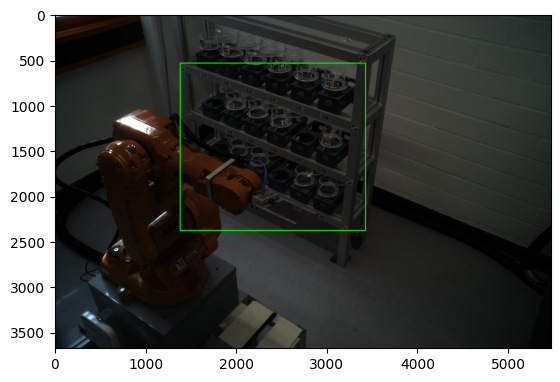

In [55]:
# extract all shelf-markers
shelf_corners = []
for marker in markers:
    if marker[0] == 0:
        shelf_corners.append(marker)
print(shelf_corners)

# draw rectangle around the shelf and the shelf rows
# first extract outer corners 
pt1x = 0
pt1y = 0
pt2x = 0
pt2y = 0
for shelfcorner in shelf_corners:
    xmin = min(shelfcorner[1][0][0][0], shelfcorner[1][0][1][0] )
    ymin = min(shelfcorner[1][0][0][1], shelfcorner[1][0][1][1])
    xmax = max(shelfcorner[1][0][0][0], shelfcorner[1][0][1][0] )
    ymax = max(shelfcorner[1][0][0][1], shelfcorner[1][0][1][1])
    pt1x = xmin if pt1x == 0 or xmin < pt1x else pt1x
    pt1y = ymin if pt1y == 0 or ymin < pt1y else pt1y
    pt2x = xmax if pt2x == 0 or xmax > pt2x else pt2x
    pt2y = ymax if pt2y == 0 or ymax > pt2y else pt2y
print(pt1x, pt1y)
print(pt2x, pt2y)
print(type(pt1x))
x_corners = [0,0,0,0]
y_corners = [0,0,0,0]

for shelfcorner in shelf_corners:
    for i in range(4):
        x = min(shelfcorner[1][0][0][0], shelfcorner[1][0][1][0]) if i in (0 , 3) else max(shelfcorner[1][0][0][0], shelfcorner[1][0][1][0])
        y = min(shelfcorner[1][0][0][1], shelfcorner[1][0][1][1]) if i in (0 , 1) else max(shelfcorner[1][0][0][1], shelfcorner[1][0][1][1])
        if i == 0 and x < 1400:
            if y < 800:
                x_corners[i] = x
                y_corners[i] = y
        elif i == 1 and x > 3000:
            if 500 < y > 1200:
                x_corners[i] = x
                y_corners[i] = y
        elif i == 2 and x > 3000:
            if 1500 < y < 2000:
                x_corners[i] = x
                y_corners[i] = y
        elif i == 3 and x < 1500:
            if y > 800:
                x_corners[i] = x
                y_corners[i] = y
print(x_corners, y_corners)

img2 = cv2.aruco.drawDetectedMarkers(img, corners, ids)
cv2.rectangle(img2, (int(pt1x), int(pt1y)), (int(pt2x), int(pt2y)), (0, 255, 0), thickness= 10)
cv2.imwrite("Ringtest_2cm,15cm.png", img2)
plt.imshow(img2)

[1378.0, 3331.0, 3265.0, 1450.0] [601.0, 1261.0, 1874.0, 1130.0]
(3672, 5472, 3)
[[1378.  601.]
 [3331. 1261.]
 [3265. 1874.]
 [1450. 1130.]]
<ProjectiveTransform(matrix=
    [[ 5.56815872e-01,  2.63521916e-01,  5.18166754e+02],
     [ 1.74623769e-01,  9.35536206e-01, -9.60939432e+02],
     [-1.00117130e-04,  1.05068598e-04,  1.00000000e+00]])>


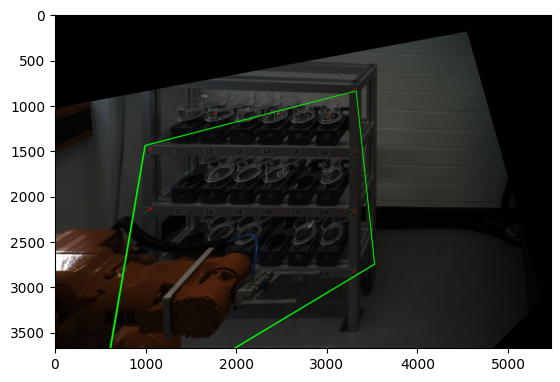

In [56]:
# 4-point distortion

from skimage import transform
import math

x_corners = [0,0,0,0]
y_corners = [0,0,0,0]
for shelfcorner in shelf_corners:
    for i in range(4):
        x = min(shelfcorner[1][0][0][0], shelfcorner[1][0][1][0]) if i in (0 , 3) else max(shelfcorner[1][0][0][0], shelfcorner[1][0][1][0])
        y = min(shelfcorner[1][0][0][1], shelfcorner[1][0][1][1]) if i in (0 , 1) else max(shelfcorner[1][0][0][1], shelfcorner[1][0][1][1])
        if i == 0 and x < 1400:
            if y < 800:
                x_corners[i] = x
                y_corners[i] = y
        elif i == 1 and x > 3000:
            if 500 < y > 1200:
                x_corners[i] = x
                y_corners[i] = y
        elif i == 2 and x > 3000:
            if 1500 < y < 2000:
                x_corners[i] = x
                y_corners[i] = y
        elif i == 3 and x < 1500:
            if y > 800:
                x_corners[i] = x
                y_corners[i] = y
print(x_corners, y_corners)

print(img2.shape)

#dx = 3352-1370
dx = max(x_corners) - min(x_corners)
#dy = 1214-538
dy = max(y_corners) - min(y_corners)
hx = math.sqrt(dx**2 + dy**2)
dh = hx/105
hy = dh*31
x_min = 0.5*dx
x_max = (x_min +hx)
y_min = 1.2*dy
y_max = y_min + hy 
src = np.array([ [x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max] ])
dst = [ [x_corners[0], y_corners[0]] ]
dst = np.vstack([dst, [x_corners[1], y_corners[1]] ])
dst = np.vstack([dst, [x_corners[2], y_corners[2]] ])
dst = np.vstack([dst, [x_corners[3], y_corners[3]] ])

# rect_image
tform3 = transform.ProjectiveTransform()
tform3.estimate(src, dst) 
print(dst)
print(tform3)
img3 =transform.warp(img2, tform3, output_shape = (img2.shape[0], img2.shape[1]))
plt.imshow(img3)
plt.show()

In [57]:
#cv2.imwrite("transformed.png", img3)
plt.imsave("transformed.png", img3)

In [58]:
# distort Rectangle 
'''
x = []
y = []
for marker in shelf_corners:
    if marker[1][0][0][0] > 3000 and marker[1][0][0][1] < 1000:
        x.append(int(marker[1][0][0][0]))
        y.append(int(marker[1][0][0][1]))
    if marker[1][0][0][0] > 3000 and marker[1][0][0][1] > 2000:
        x.append(int(marker[1][0][0][0]))
        y.append(int(marker[1][0][0][1]))
for marker in shelf_corners:
    if marker[1][0][0][0] < 1600 and marker[1][0][0][1] < 600:
        x.append(int(marker[1][0][0][0]))
        y.append(int(marker[1][0][0][1]))
    if marker[1][0][0][0] < 1600 and marker[1][0][0][1] > 900:
        x.append(int(marker[1][0][0][0]))
        y.append(int(marker[1][0][0][1]))
cv2.line(img2, (x[0], y[0]), (x[1], y[1]), color=(0,255,0), thickness= 15)
cv2.line(img2, (x[2], y[2]), (x[3], y[3]), color= (0,255,0), thickness= 15)
alpha = np.arctan2(int(x[1])-int(x[0]), int(y[1])-int(y[0]))*180/np.pi
print(alpha)
cv2.line(img2, (x[0], y[0]), (x[2] , int(y[0]+int(x[2]-x[0])*np.sin(-alpha*np.pi/180))),color= (0,255,0), thickness= 15 )
rotation_matrix = cv2.getRotationMatrix2D((img2.shape[1] / 2, img2.shape[0] / 2), -alpha, 1.0)
img2 = cv2.warpAffine(img2, rotation_matrix, (img2.shape[1], img2.shape[0]))
cv2.imwrite("Ringtest_2cm,15cm_rotated_and warped.png", img2)
plt.imshow(img2) '''

'\nx = []\ny = []\nfor marker in shelf_corners:\n    if marker[1][0][0][0] > 3000 and marker[1][0][0][1] < 1000:\n        x.append(int(marker[1][0][0][0]))\n        y.append(int(marker[1][0][0][1]))\n    if marker[1][0][0][0] > 3000 and marker[1][0][0][1] > 2000:\n        x.append(int(marker[1][0][0][0]))\n        y.append(int(marker[1][0][0][1]))\nfor marker in shelf_corners:\n    if marker[1][0][0][0] < 1600 and marker[1][0][0][1] < 600:\n        x.append(int(marker[1][0][0][0]))\n        y.append(int(marker[1][0][0][1]))\n    if marker[1][0][0][0] < 1600 and marker[1][0][0][1] > 900:\n        x.append(int(marker[1][0][0][0]))\n        y.append(int(marker[1][0][0][1]))\ncv2.line(img2, (x[0], y[0]), (x[1], y[1]), color=(0,255,0), thickness= 15)\ncv2.line(img2, (x[2], y[2]), (x[3], y[3]), color= (0,255,0), thickness= 15)\nalpha = np.arctan2(int(x[1])-int(x[0]), int(y[1])-int(y[0]))*180/np.pi\nprint(alpha)\ncv2.line(img2, (x[0], y[0]), (x[2] , int(y[0]+int(x[2]-x[0])*np.sin(-alpha*np.pi